In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mmHg, bar
from uncertainties import ufloat
from uncertainties import unumpy
from uncertainties.umath import sqrt
from scipy import odr

In [7]:
# constants
u_sigma = 0.0005 # %
conversion_mmhg_bar = mmHg / bar
epsilon = ufloat(1*10**(-3), 0)
gamma = ufloat(1*10**(-5), 0) # 1/°C
t_e = ufloat(0, 0.5) # ice water temperatur in °C

# Calibration

[1.26424976e-14 4.22235307e-14]


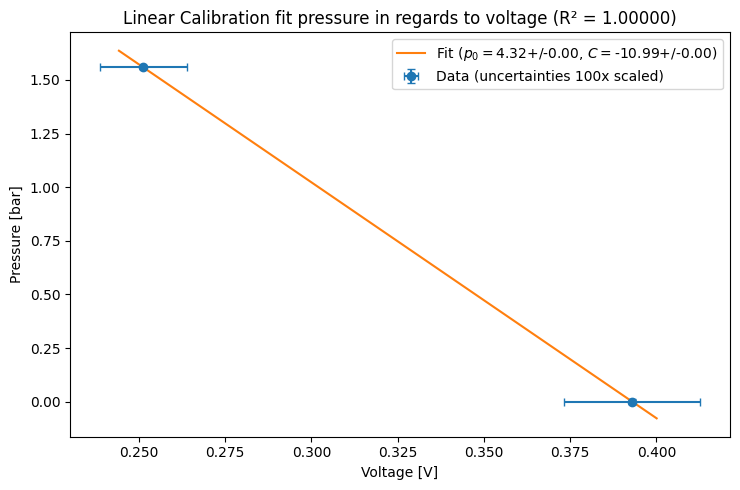

4.320932619159270+/-0.000000000000013 -10.99448503602868+/-0.00000000000004


In [8]:
p_l_mmhg = ufloat(1171.6-2.99, 0.05) # adjust pressure of room in mmhg

u_l = 0.2513  # adjust in V
u_t = 0.3930 # adjust in V

p_t = ufloat(0.1*10**(-3), 0.1*10**(-3)) # pressure pump in bar
p_l = p_l_mmhg * conversion_mmhg_bar # pressure of room in bar

u_l = ufloat(u_l, u_l*u_sigma)
u_t = ufloat(u_t, u_t*u_sigma)

p = unumpy.uarray([p_l.n, p_t.n], [p_l.s, p_t.s])
u = unumpy.uarray([u_l.n, u_t.n],[u_l.s, u_t.s])

x = unumpy.nominal_values(u)
y = unumpy.nominal_values(p)
sx = unumpy.std_devs(u)
sy = unumpy.std_devs(p)

# fit function
def calibration_curve(beta, u):
    p0, C = beta
    return p0 + C * u

# fit
model = odr.Model(calibration_curve)
data = odr.RealData(x, y, sx=sx, sy=sy)
odr_run = odr.ODR(data, model, beta0=[1, 1]).run()

p0_fit, C_fit = odr_run.beta
p0_err, C_err = odr_run.sd_beta

# convert to ufloat
p0_u = ufloat(p0_fit, p0_err)
C_u  = ufloat(C_fit,  C_err)

# r2-score
y_hat = calibration_curve(odr_run.beta, x)
ss_res = np.sum((y - y_hat)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1.0 - ss_res/ss_tot

# plot
u_min, u_max = np.min(x), np.max(x)
u_pad = 0.05 * (u_max - u_min)
u_fit = np.linspace(u_min - u_pad, u_max + u_pad, 1000)
p_fit = calibration_curve(odr_run.beta, u_fit)

plt.figure(figsize=(7.5, 5))
plt.errorbar(x, y, xerr=sx*100, yerr=sy*100, fmt='o', capsize=3, label='Data (uncertainties 100x scaled)')
plt.plot(u_fit, p_fit, '-', label=fr'Fit ($p_0 = ${p0_u:.2f}, $C = ${C_u:.2f})')

plt.xlabel('Voltage [V]')
plt.ylabel('Pressure [bar]')
plt.title(f'Linear Calibration fit pressure in regards to voltage (R² = {r_squared:.5f})')
plt.legend(loc='best')
plt.tight_layout()
plt.savefig('p_u_calibration.png', dpi=600)
plt.show()
print(p0_u, C_u)

# Absolute Zero

In [9]:
u_e = 0.2888 # adjust voltage for ice water in V
u_k = 0.2516 # adjust voltage for boiling water in V
t_k = ufloat(98.285, 0.0005) # adjust boiling point of water in °C
t_l = ufloat(23.4, 0.05) # adjust room temperature in °C

u_e = ufloat(u_e, u_e*u_sigma)
u_k = ufloat(u_k, u_k*u_sigma)

def pressure_func(p0, C, u):
    return p0 + C * u

p_e = ufloat(pressure_func(p0_u, C_u, u_e).n, pressure_func(p0_u, C_u, u_e).s)
p_k = ufloat(pressure_func(p0_u, C_u, u_k).n, pressure_func(p0_u, C_u, u_k).s)

a = (1 + epsilon) * p_e - (1 + epsilon + gamma * t_k) * p_k
b = epsilon * (p_k - p_e) * t_k + (1 + gamma * t_k) * p_k * t_l - p_e * (t_l + t_k)
c = p_e * t_l * t_k

t_0_est = p_e/(p_k-p_e)*t_k
t_0 = (-b + sqrt(b**2 - 4 * a * c) ) / (2 * a)
print(f"rough estimate for absolute zero temperature: -{t_0_est:.2f} °C")
print(f"Absolute zero temperature: {t_0:.2f} °C")

rough estimate for absolute zero temperature: -275.33+/-1.72 °C
Absolute zero temperature: -273.96+/-1.71 °C


# liquid Nitrogen

In [10]:
u_ln2 = 0.3636 # adjust voltage of liquid nitrogen in V

u_ln2 = ufloat(u_ln2, u_ln2*u_sigma)
p_ln2 = ufloat(pressure_func(p0_u, C_u, u_ln2).n, pressure_func(p0_u, C_u, u_ln2).s)

A = p_e / (t_e-t_0) + (epsilon * (p_e - p_ln2)) / (t_l - t_0)
print(f"corr. coeff A = {A:.5f}")

t_ln2_est = (1 - (p_ln2/p_e))*t_0
t_ln2 = (A * t_0 + p_ln2) / (A - gamma * p_ln2)
print(f"rough estimate for the temperature of liquid nitrogen: {t_ln2_est:.2f} °C")
print(f"Temperature of liquid nitrogen: {t_ln2:.2f} °C")

corr. coeff A = 0.00418+/-0.00002
rough estimate for the temperature of liquid nitrogen: -196.65+/-1.40 °C
Temperature of liquid nitrogen: -196.85+/-1.41 °C
